In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-filtering/HEOG.mat
/kaggle/input/eeg-filtering/Contaminated_Data.mat
/kaggle/input/eeg-filtering/Pure_Data.mat
/kaggle/input/eeg-filtering/VEOG.mat


In [2]:
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [3]:
contaminated_data = sio.loadmat("/kaggle/input/eeg-filtering/Contaminated_Data.mat")

In [4]:
pure_data = sio.loadmat("/kaggle/input/eeg-filtering/Pure_Data.mat")

In [5]:
veog=sio.loadmat("/kaggle/input/eeg-filtering/VEOG.mat")
heog=sio.loadmat("/kaggle/input/eeg-filtering/HEOG.mat")

In [6]:
pure_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Apr 09 11:58:16 2009',
 '__version__': '1.0',
 '__globals__': [],
 'sim1_resampled': array([[ 11.333812 ,  12.3151865,  10.298577 , ...,   8.509107 ,
           9.605591 ,   5.8658404],
        [-13.910137 , -25.642948 , -25.847677 , ...,  -1.4506483,
          -1.4239422,  -0.4805555],
        [ 13.081046 ,  14.299351 ,  12.183936 , ...,  18.124468 ,
          18.86998  ,  10.743347 ],
        ...,
        [  4.4241457,   3.7565234,   2.471671 , ...,  11.324605 ,
          11.291225 ,   5.9086432],
        [  6.063719 ,   6.5755897,   5.641155 , ...,   3.1459832,
           3.504593 ,   1.6918699],
        [  9.5622015,   6.000428 ,  -0.6029951, ...,  14.696908 ,
          14.113103 ,   7.0015345]], dtype=float32),
 'sim2_resampled': array([[ -0.77562565,  10.107471  ,  15.634752  , ...,   9.311941  ,
          16.272224  ,  14.322681  ],
        [ -7.9340324 ,  14.817395  ,  30.832073  , ...,  28.46614   ,
       

In [7]:
contaminated_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue May 05 15:50:09 2009',
 '__version__': '1.0',
 '__globals__': [],
 'sim1_con': array([[ 11.31871986,  12.29839897,  10.28273773, ...,  66.90544128,
          68.03845215,  64.36378479],
        [-13.92522812, -25.65973663, -25.86351585, ...,  56.94568634,
          57.00891495,  58.0173912 ],
        [ 10.39846134,  11.56166363,   9.39088535, ...,  39.89983749,
          40.64390945,  32.52783966],
        ...,
        [  5.26071739,   4.60958052,   3.34262848, ...,  33.87456894,
          33.86003113,  28.50689697],
        [  6.43552828,   6.95472622,   6.02824688, ...,  13.1681881 ,
          13.53517151,  11.73553753],
        [  9.35468769,   5.78854561,  -0.81906354, ...,  20.86396217,
          20.28285599,  13.17710686]]),
 'sim2_con': array([[57.81217957, 68.80786133, 74.46704102, ..., 20.71664429,
         27.62337494, 25.6267395 ],
        [50.65377426, 73.51778412, 89.66436005, ..., 39.87084198,
        

In [8]:
veog

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Thu Apr 09 12:03:32 2009',
 '__version__': '1.0',
 '__globals__': [],
 'veog_1': array([[  4.6476192,   4.7392063,   4.8386517, ..., 125.277565 ,
         125.38224  , 125.545845 ]], dtype=float32),
 'veog_2': array([[125.760086, 126.02073 , 126.32036 , ...,  22.22218 ,  22.132553,
          22.055893]], dtype=float32),
 'veog_3': array([[ 21.993124,  21.943457,  21.90788 , ..., -85.56464 , -85.571014,
         -85.535614]], dtype=float32),
 'veog_4': array([[-85.46141  , -85.354355 , -85.21911  , ...,   2.4741497,
           2.0528784,   1.6558485]], dtype=float32),
 'veog_5': array([[   1.2896323 ,    0.96030235,    0.67330265, ..., -109.98629   ,
         -109.47146   , -108.93102   ]], dtype=float32),
 'veog_6': array([[-108.364815, -107.773056, -107.159775, ...,   18.606386,
           18.273829,   17.971004]], dtype=float32),
 'veog_7': array([[ 17.700716,  17.46804 ,  17.275578, ..., -32.077545, -32.11658 ,
     

In [9]:
# Extract EEG Signals
contaminated_signal = contaminated_data['sim1_con']  # Shape: (samples, channels, timepoints)
pure_signal = pure_data['sim1_resampled']
veog_signal=veog['veog_1']
heog_signal=heog['heog_1']

In [10]:
pure_signal[0]

array([11.333812 , 12.3151865, 10.298577 , ...,  8.509107 ,  9.605591 ,
        5.8658404], dtype=float32)

In [11]:
veog_signal[0]

array([  4.6476192,   4.7392063,   4.8386517, ..., 125.277565 ,
       125.38224  , 125.545845 ], dtype=float32)

In [12]:
heog_signal[0]

array([-43.989456, -44.8843  , -45.800106, ...,  -9.682404,  -9.935913,
       -10.171984], dtype=float32)

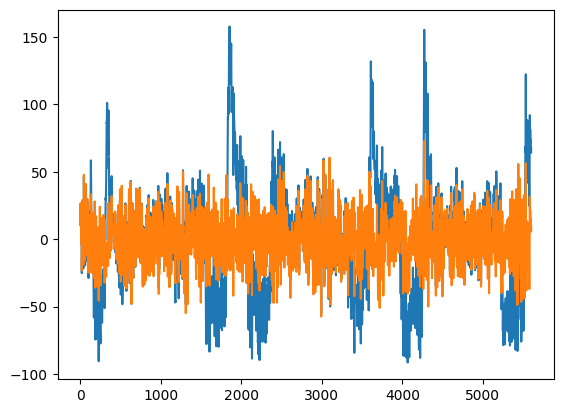

In [13]:
plt.plot(contaminated_signal[0])  # Correct for 1D arrays
plt.plot(pure_signal[0])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

def rls_filter(desired, reference, filter_order, lam=0.99, delta=0.01):
    """
    Implements a single-input RLS adaptive filter.

    Parameters:
        desired : 1D numpy array
            The desired signal (e.g., the contaminated EEG signal you want to clean).
        reference : 1D numpy array
            The reference signal (e.g., an artifact channel such as VEOG or HEOG).
        filter_order : int
            The number of filter taps (length of the filter).
        lam : float, optional
            Forgetting factor (0 < lam <= 1). A value close to 1 gives long memory.
        delta : float, optional
            Regularization parameter used to initialize the inverse correlation matrix.

    Returns:
        y : 1D numpy array
            The filter output (artifact estimate or cleaned signal, depending on context).
        e : 1D numpy array
            The error signal (difference between desired and filter output).
        w_history : 2D numpy array
            History of the weight vectors at each iteration (each row is the weight vector at time n).
    """
    n_samples = len(desired)

    # Initialize the weight vector (filter coefficients) to zeros.
    w = np.zeros(filter_order)

    # Initialize the inverse correlation matrix P.
    P = (1.0 / delta) * np.eye(filter_order)

    # Preallocate arrays for filter output and error.
    y = np.zeros(n_samples)
    e = np.zeros(n_samples)

    # For optionally tracking the weight evolution over time.
    w_history = np.zeros((n_samples, filter_order))

    # Loop over each sample starting from 'filter_order' so that we have a complete regressor.
    for n in range(filter_order, n_samples):
        # Form the regressor vector from the reference signal.
        # We use the past 'filter_order' samples, reversed so that the most recent sample comes first.
        x = reference[n - filter_order:n][::-1]
        # Reshape x to a column vector for matrix operations.
        x = x.reshape(-1, 1)

        # Compute the gain vector k(n):
        # k = P(n-1) * x(n) / (lam + x(n)^T * P(n-1) * x(n))
        numerator = np.dot(P, x)  # P * x, shape: (filter_order, 1)
        denominator = lam + np.dot(x.T, numerator)  # scalar value
        k = numerator / denominator  # shape: (filter_order, 1)

        # Compute the filter output: y(n) = w(n-1)^T * x(n)
        y[n] = np.dot(w, x.flatten())

        # Compute the error: e(n) = d(n) - y(n)
        e[n] = desired[n] - y[n]

        # Update the weight vector: w(n) = w(n-1) + k(n)*e(n)
        w = w + (k.flatten() * e[n])

        # Save the current weight vector to history (optional)
        w_history[n, :] = w

        # Update the inverse correlation matrix:
        # P(n) = (P(n-1) - k(n) * x(n)^T * P(n-1)) / lam
        P = (P - np.dot(k, np.dot(x.T, P))) / lam

    return y, e, w_history

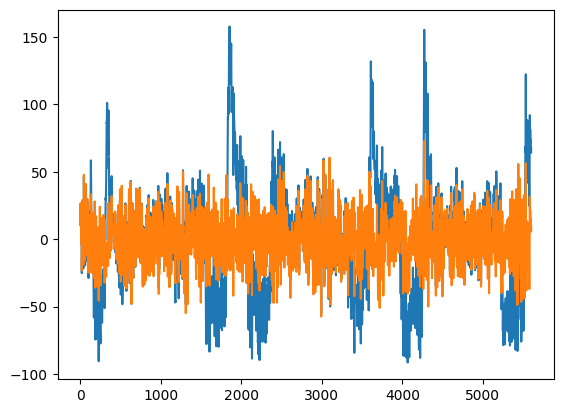

In [15]:
plt.plot(contaminated_signal[0])
plt.plot(pure_signal[0])

In [16]:
min_length=1000000
for i in range(0 ,19):
    min_length = min(min_length,len(contaminated_signal[i]), len(pure_signal[i]), len(veog_signal[0]), len(heog_signal[0]))
    contaminated_signal[i] = contaminated_signal[i][:min_length]
    pure_signal[i] = pure_signal[i][ :min_length]
    veog_signal = veog_signal[:min_length]
    heog_signal = heog_signal[:min_length]
    #Some have 5801 points also so min length should come as 5601
print(min_length)

5601


In [17]:
# y1_l = []
# e1_l = []
# w1_l = []
# y2_l = []
# e2_l = []
# w2_l = []

In [18]:
contaminated_signal[0]

array([11.31871986, 12.29839897, 10.28273773, ..., 66.90544128,
       68.03845215, 64.36378479])

In [19]:
print(veog_signal.shape,heog_signal.shape)

(1, 5601) (1, 5601)


In [20]:
y1_all = []  # VEOG artifact estimates
e1_all = []  # After VEOG removal
w1_all = []

y2_all = []  # HEOG artifact estimates
e2_all = []  # Final cleaned signals (after HEOG removal)
w2_all = []

for i in range(1, 55):  # sim1 to sim54
    key = f'sim{i}_con'
    contaminated_signal = contaminated_data[key][:5601]  # Shape: (19, timepoints)
    veog_signal=veog[f'veog_{i}'][:5601]
    heog_signal=heog[f'heog_{i}'][:5601]
    
    y1_channels = []
    e1_channels = []
    w1_channels = []

    y2_channels = []
    e2_channels = []
    w2_channels = []

    for ch in range(contaminated_signal.shape[0]):  # Loop over 19 channels
        # Step 1: VEOG removal
        y1, e1, w1 = rls_filter(
            desired=contaminated_signal[ch],
            reference=veog_signal[0],
            filter_order=4,
            lam=1.0,
            delta=0.1
        )

        # Step 2: HEOG removal on the VEOG-cleaned signal
        y2, e2, w2 = rls_filter(
            desired=e1,  # use VEOG-cleaned signal
            reference=heog_signal[0],
            filter_order=4,
            lam=1.0,
            delta=0.1
        )

        # Append results for this channel
        y1_channels.append(y1)
        e1_channels.append(e1)
        w1_channels.append(w1)

        y2_channels.append(y2)
        e2_channels.append(e2)
        w2_channels.append(w2)

    # Append results for this sample (sim_i)
    y1_all.append(y1_channels)
    e1_all.append(e1_channels)
    w1_all.append(w1_channels)

    y2_all.append(y2_channels)
    e2_all.append(e2_channels)
    w2_all.append(w2_channels)


In [21]:
# y1_l[0].shape

In [22]:
# for i in range(0 ,19):
#     y2 , e2 , w2 = rls_filter(contaminated_signal[i] - y1_l[i] , heog_signal[0], 4,1.0,0.1 )
#     y2_l.append(y2)
#     e2_l.append(e2)
#     w2_l.append(w2)

In [23]:
contaminated_signal[0]

array([-3.17471504, -2.69913673,  0.42729282, ..., 38.15830231,
       37.50923157, 37.12720871])

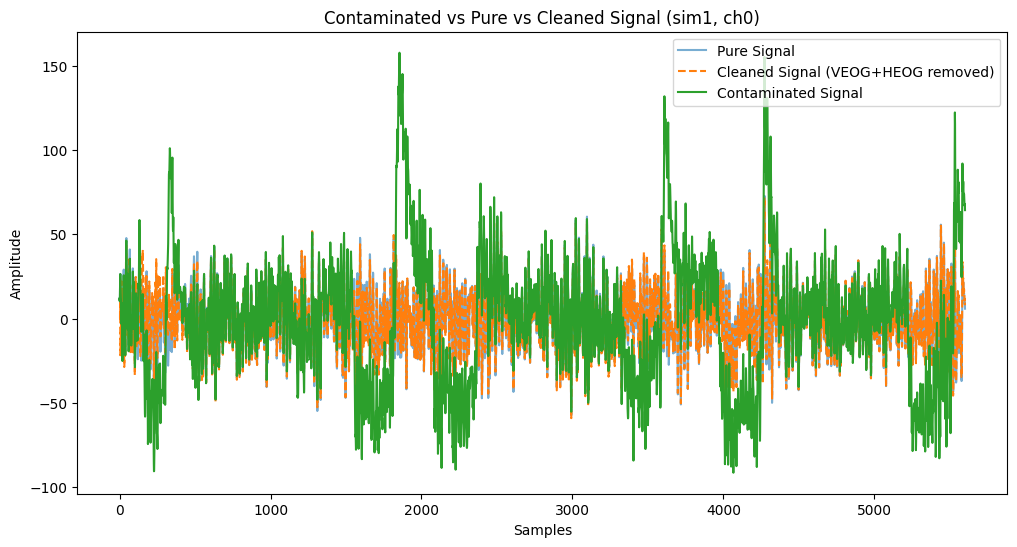

In [24]:
sample_idx = 0  # sim1
channel = 0

sim_key = f'sim{sample_idx+1}_con'
pure_key = f'sim{sample_idx+1}_resampled'
veog_key = f'veog_{sample_idx+1}'
heog_key = f'heog_{sample_idx+1}'

# Fetch signals from their respective sources
pure = pure_data[pure_key][channel]
contaminated = contaminated_data[sim_key][channel]
veog_estimate = y1_all[sample_idx][channel]
heog_estimate = y2_all[sample_idx][channel]
cleaned = e2_all[sample_idx][channel]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(pure, label='Pure Signal', alpha=0.6)
plt.plot(cleaned, label='Cleaned Signal (VEOG+HEOG removed)', linestyle='dashed')
plt.plot(contaminated, label='Contaminated Signal')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title(f'Contaminated vs Pure vs Cleaned Signal (sim{sample_idx+1}, ch{channel})')
plt.show()


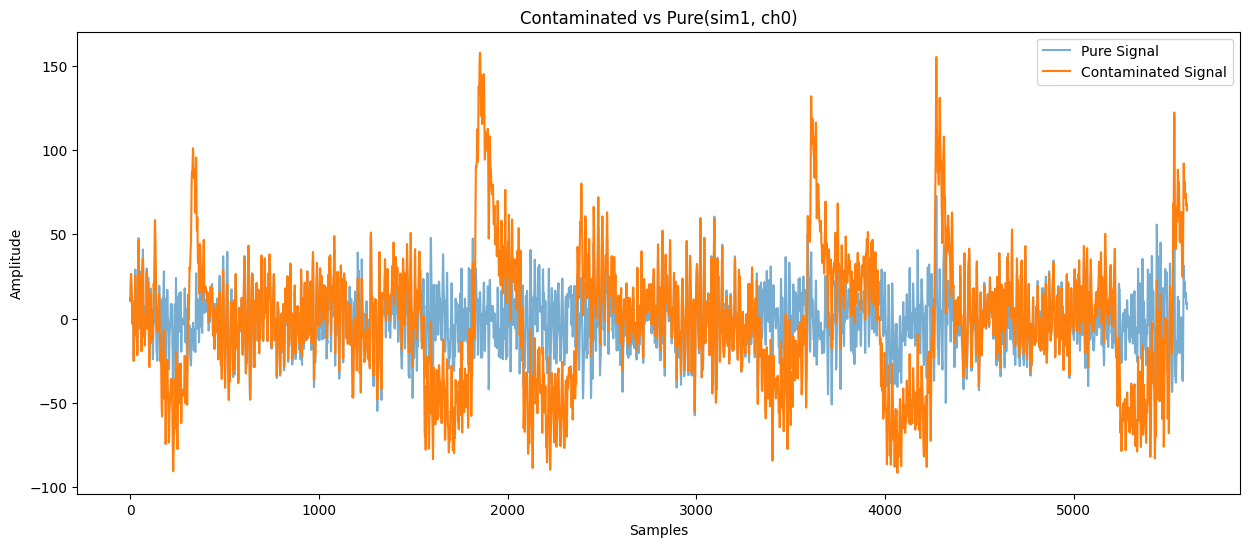

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(pure, label='Pure Signal', alpha=0.6)
# plt.plot(cleaned, label='Cleaned Signal (VEOG+HEOG removed)', linestyle='dashed')
plt.plot(contaminated, label='Contaminated Signal')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title(f'Contaminated vs Pure(sim{sample_idx+1}, ch{channel})')
plt.show()

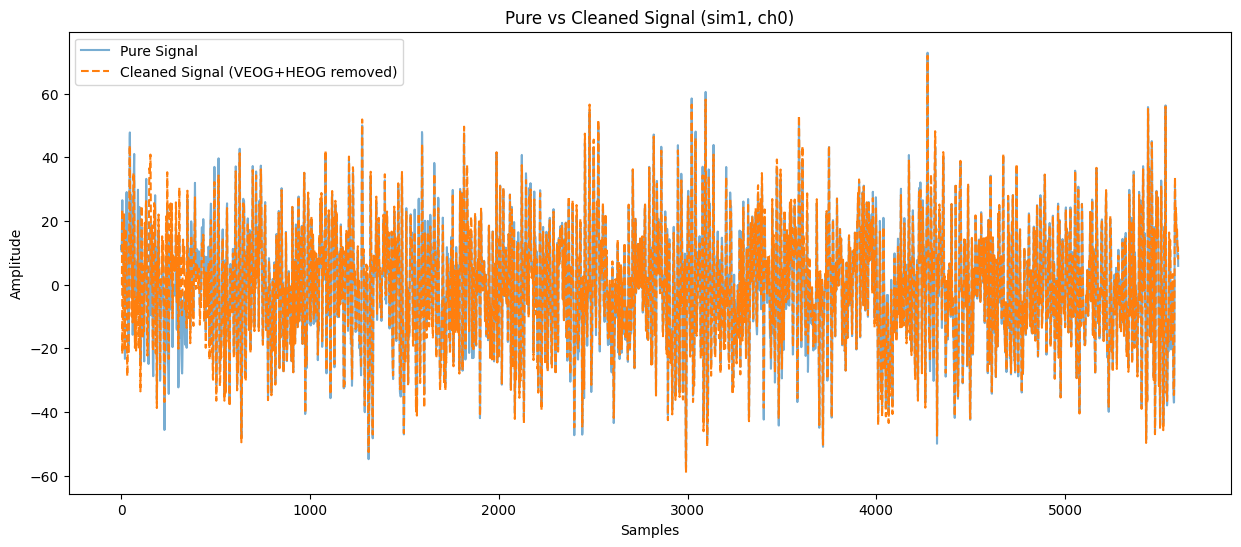

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(pure, label='Pure Signal', alpha=0.6)
plt.plot(cleaned, label='Cleaned Signal (VEOG+HEOG removed)', linestyle='dashed')
# plt.plot(contaminated, label='Contaminated Signal')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title(f'Pure vs Cleaned Signal (sim{sample_idx+1}, ch{channel})')
plt.show()

In [27]:
print(len(e2_all),len(e2_all[0]),len(e2_all[0][0]))
for i in range(0,19):
    print(len(e2_all[0][i]))

54 19 5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601
5601


In [28]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Find the minimum length across all signals
min_length = min(
    [len(np.array(e2_all[i][ch])) for i in range(54) for ch in range(19)]
)

# Now, truncate to the minimum length for all signals
cleaned_data = []
pure_data_list = []

for i in range(53):  # 53 simulations leaving last simulation unseen 
    sim_cleaned = []
    sim_pure = []
    for ch in range(19):  # 19 channels
        # Truncate to the minimum length
        cleaned_signal = np.array(e2_all[i][ch])[:min_length]
        pure_signal = np.array(pure_data[f'sim{i+1}_resampled'][ch])[:min_length]

        sim_cleaned.append(cleaned_signal)
        sim_pure.append(pure_signal)
    
    cleaned_data.append(sim_cleaned)
    pure_data_list.append(sim_pure)

# Convert to tensors: shape (54, 19, min_length)
cleaned_tensor = torch.tensor(cleaned_data, dtype=torch.float32)
pure_tensor = torch.tensor(pure_data_list, dtype=torch.float32)

# Reshape to (1026, 1, min_length) for channel-wise training
inputs_tensor = cleaned_tensor.view(-1, 1, min_length)
targets_tensor = pure_tensor.view(-1, 1, min_length)

# Dataset and Dataloader
class EEGDenoisingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = EEGDenoisingDataset(inputs_tensor, targets_tensor)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


/tmp/ipykernel_19/3333910236.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  cleaned_tensor = torch.tensor(cleaned_data, dtype=torch.float32)


In [29]:
print(min_length)

5401


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------- IC-U-Net Definition --------- but one channel at a time now
class ICUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(ICUNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.bottleneck = self.conv_block(256, 512)
        self.decoder3 = self.conv_block(512 + 256, 256)
        self.decoder2 = self.conv_block(256 + 128, 128)
        self.decoder1 = self.conv_block(128 + 64, 64)
        self.final_layer = nn.Conv1d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        bottleneck = self.bottleneck(enc3)
        dec3 = self.decoder3(torch.cat([bottleneck, enc3], dim=1))
        dec2 = self.decoder2(torch.cat([dec3, enc2], dim=1))
        dec1 = self.decoder1(torch.cat([dec2, enc1], dim=1))
        return self.final_layer(dec1)

# --------- Dataset ---------
class EEGDenoisingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --------- Training Function ---------
def train_ICUNet(model, train_loader, num_epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.6f}")

# --------- Normalization Function ---------
def normalize(signal):
    signal = np.array(signal)
    return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

# --------- Determine Minimum Length ---------
min_length = min(
    len(np.array(e2_all[i][ch]))
    for i in range(54)
    for ch in range(19)
)

# --------- Training Loop ---------
for i in range(54):  # For each simulation
    for ch in range(19):  # For each channel
        print(f"\nTraining ICUNet -> Simulation {i+1}, Channel {ch+1}")

        # Extract and preprocess signals
        cleaned = normalize(e2_all[i][ch])[:min_length]
        pure = normalize(pure_data[f'sim{i+1}_resampled'][ch])[:min_length]

        # Convert to PyTorch tensors and reshape
        X_tensor = torch.tensor(cleaned, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        y_tensor = torch.tensor(pure, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        # Dataset & Dataloader
        dataset = EEGDenoisingDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=1, shuffle=True)

        # Initialize and train the model
        model = ICUNet().to(device)
        train_ICUNet(model, loader, num_epochs=10, lr=1e-3)



Training ICUNet -> Simulation 1, Channel 1
Epoch 1/10, Loss: 1.133999
Epoch 2/10, Loss: 0.333242
Epoch 3/10, Loss: 0.210773
Epoch 4/10, Loss: 0.162248
Epoch 5/10, Loss: 0.140382
Epoch 6/10, Loss: 0.114587
Epoch 7/10, Loss: 0.104483
Epoch 8/10, Loss: 0.096164
Epoch 9/10, Loss: 0.091496
Epoch 10/10, Loss: 0.090458

Training ICUNet -> Simulation 1, Channel 2
Epoch 1/10, Loss: 1.028943
Epoch 2/10, Loss: 0.357833
Epoch 3/10, Loss: 0.176664
Epoch 4/10, Loss: 0.149447
Epoch 5/10, Loss: 0.153694
Epoch 6/10, Loss: 0.134737
Epoch 7/10, Loss: 0.127536
Epoch 8/10, Loss: 0.119623
Epoch 9/10, Loss: 0.119056
Epoch 10/10, Loss: 0.109836

Training ICUNet -> Simulation 1, Channel 3
Epoch 1/10, Loss: 1.029154
Epoch 2/10, Loss: 0.467090
Epoch 3/10, Loss: 0.185501
Epoch 4/10, Loss: 0.162895
Epoch 5/10, Loss: 0.139645
Epoch 6/10, Loss: 0.137279
Epoch 7/10, Loss: 0.123788
Epoch 8/10, Loss: 0.113405
Epoch 9/10, Loss: 0.109030
Epoch 10/10, Loss: 0.109396

Training ICUNet -> Simulation 1, Channel 4
Epoch 1/10,

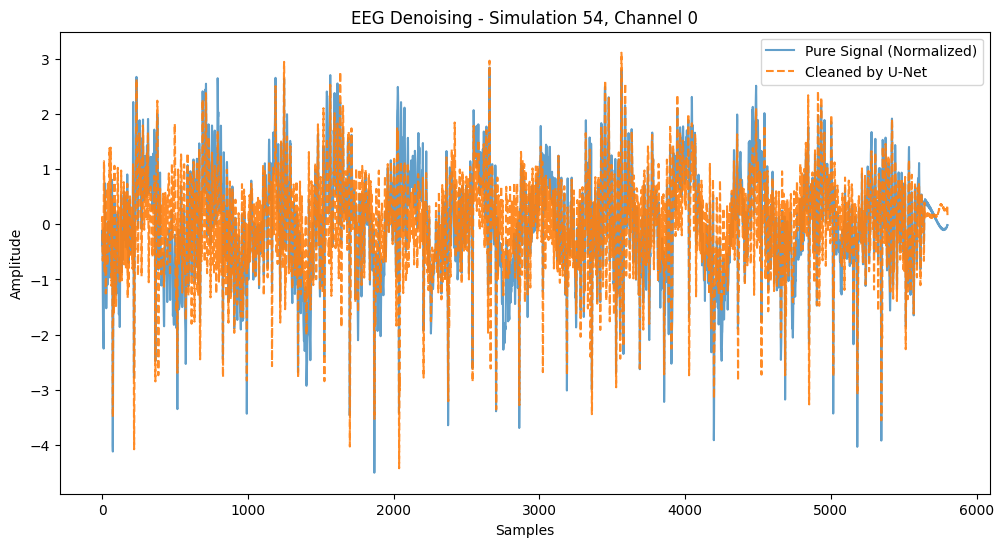

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

test_cleaned = []
test_pure = []

min_length = min([len(np.array(e2_all[53][ch])) for ch in range(19)])

for ch in range(19):
    cleaned = np.array(e2_all[53][ch])[:min_length]
    pure = np.array(pure_data['sim54_resampled'][ch])[:min_length]

    cleaned = (cleaned - np.mean(cleaned)) / np.std(cleaned)
    pure = (pure - np.mean(pure)) / np.std(pure)

    test_cleaned.append(cleaned)
    test_pure.append(pure)

# Convert to torch tensor
test_cleaned_tensor = torch.tensor(test_cleaned, dtype=torch.float32).unsqueeze(1).to(device)  # (19, 1, T)

# Run inference
model.eval()
with torch.no_grad():
    denoised_output = model(test_cleaned_tensor).cpu().squeeze(1).numpy()  # Shape: (19, T)

# Plot for channel 0
channel = 0
contaminated = test_cleaned[channel]
predicted_clean = denoised_output[channel]
true_clean = test_pure[channel]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(true_clean, label='Pure Signal (Normalized)', alpha=0.7)
# plt.plot(contaminated, label='Contaminated Signal (Normalized)', alpha=0.5)
plt.plot(predicted_clean, label='Cleaned by U-Net', linestyle='dashed', alpha=0.9)
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('EEG Denoising - Simulation 54, Channel 0')
plt.show()




In [32]:
import torch
import torch.nn as nn
import numpy as np

model.eval()
criterion = nn.MSELoss()
channel_losses = []

with torch.no_grad():
    for ch in range(19):
        # Get signals
        cleaned_signal = np.array(e2_all[53][ch])[:min_length]
        pure_signal = np.array(pure_data[f'sim54_resampled'][ch])[:min_length]

        # Normalize
        cleaned_norm = (cleaned_signal - cleaned_signal.mean()) / (cleaned_signal.std() + 1e-8)
        pure_norm = (pure_signal - pure_signal.mean()) / (pure_signal.std() + 1e-8)

        # Convert to tensor
        input_tensor = torch.tensor(cleaned_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        target_tensor = torch.tensor(pure_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Forward pass
        output = model(input_tensor)
        loss = criterion(output, target_tensor)

        # Store per-channel loss
        channel_losses.append(loss.item())
        print(f"Channel {ch+1:02d} - Loss: {loss.item():.6f}")

# Average loss
avg_loss = sum(channel_losses) / len(channel_losses)
print(f"\n Average Test Loss on Simulation 54 (All Channels): {avg_loss:.6f}")


Channel 01 - Loss: 0.302666
Channel 02 - Loss: 0.582738
Channel 03 - Loss: 0.261857
Channel 04 - Loss: 0.590966
Channel 05 - Loss: 0.235316
Channel 06 - Loss: 0.627242
Channel 07 - Loss: 0.214633
Channel 08 - Loss: 0.584734
Channel 09 - Loss: 0.287578
Channel 10 - Loss: 0.676737
Channel 11 - Loss: 0.586429
Channel 12 - Loss: 0.906295
Channel 13 - Loss: 0.404599
Channel 14 - Loss: 0.835008
Channel 15 - Loss: 0.286863
Channel 16 - Loss: 0.700334
Channel 17 - Loss: 0.348909
Channel 18 - Loss: 0.313694
Channel 19 - Loss: 0.298853

 Average Test Loss on Simulation 54 (All Channels): 0.476076
